# **Load libraries**

In [1]:
#Import necessary libraries 
import numpy as np 
import pandas as pd
import re 
import string 

#Text preprocessing and analysis
from textblob import TextBlob
from nltk.corpus import stopwords

#Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 

#Machine learning 
from sklearn.pipeline import Pipeline 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC




# **Load Dataset**

In [2]:
#Load the dataset with latin-1 encoding to handle special character
df=pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin-1')

#Rename columns v1 to class v2 to sms
df.rename(columns={'v1': 'class', 'v2': 'sms'}, inplace=True)

#remove columns with 90% or greater missing values
threshold = 0.9 #Define the threshold 
missing_percentage = df.isnull().mean()
columns_to_drop = missing_percentage[missing_percentage>=threshold].index
df = df.drop(columns=columns_to_drop)

#Display a random sample of 10 rows and remaining columns 
print("Remmaining columns:", df.columns)
df = df.drop_duplicates()
df.sample(10)




Remmaining columns: Index(['class', 'sms'], dtype='object')


,class,sms
2309,ham,"I have 2 sleeping bags, 1 blanket and paper an..."
1907,ham,ELLO BABE U OK?
5459,ham,If you hear a loud scream in about &lt;#&gt; m...
5534,ham,Ok which your another number
2911,ham,You didn't have to tell me that...now i'm thin...
928,ham,Oh all have to come ah?
4654,ham,Our Prasanth ettans mother passed away last ni...
4594,ham,Yo sorry was in the shower sup
2230,ham,Hey... Thk we juz go accordin to wat we discus...
777,ham,\Hi its Kate it was lovely to see you tonight ...


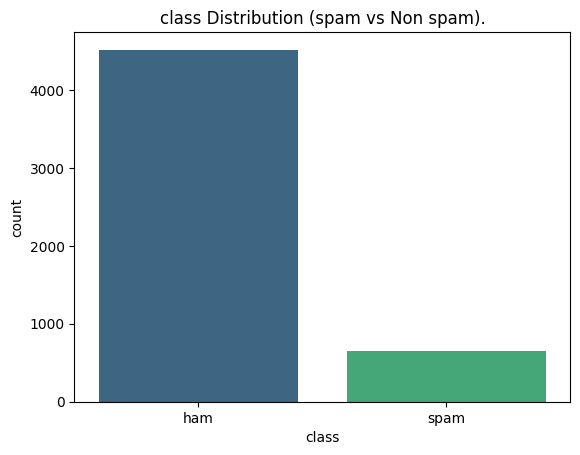

In [3]:
sns.countplot(x='class', data=df, palette="viridis")
plt.title("class Distribution (spam vs Non spam).")
plt.xlabel("class")
plt.ylabel("count")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

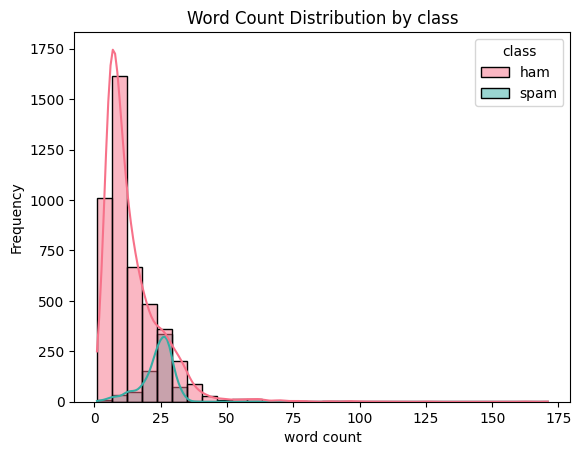

In [4]:
df['word_count'] = df['sms'].apply(lambda x: len(x.split()))
sns.histplot(data=df, x='word_count', hue='class', bins=30, kde=True, palette="husl")
plt.title("Word Count Distribution by class")
plt.xlabel("word count")
plt.ylabel("Frequency")
plt.show()

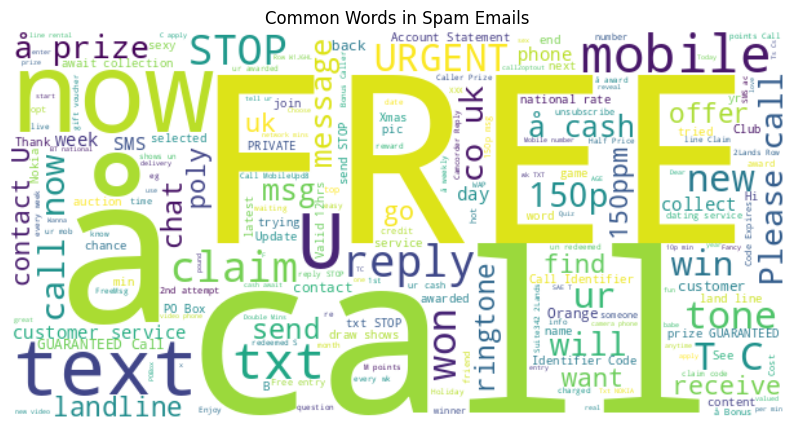

In [5]:
spam_text = df[df['class']=='spam']['sms'].str.cat(sep=' ')
wordcloud = WordCloud(width=600, height=300, background_color='white').generate(spam_text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Spam Emails")
plt.show()

In [6]:
# remove tags 
def remove_tag(text):
    pattren = re.compile('<[^>]+>')
    return pattren.sub(r'', text)
# remove URLs 
def remove_urls(text):
    pattren = re.compile(r'\b(?:https?|ftp|www)\S+\b')
    return pattren.sub(r'', text)

import re
def remove_emojis(text):
    # Define a regex pattern to match emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F700-\U0001F77F"  # Alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        "]+", flags=re.UNICODE
    )
    # Substitute emojis with an empty string
    return emoji_pattern.sub(r'', text)
# Define a dictionary of chat word mappings
chat_words = {
"AFAIK": "As Far As I Know",
"AFK": "Away From Keyboard",
"ASAP": "As Soon As Possible",
"ATK": "At The Keyboard",
"ATM": "At The Moment",
"A3": "Anytime, Anywhere, Anyplace",
"BAK": "Back At Keyboard",
"BBL": "Be Back Later",
"BBS": "Be Back Soon",
"BFN": "Bye For Now",
"B4N": "Bye For Now",
"BRB": "Be Right Back",
"BRT": "Be Right There",
"BTW": "By The Way",
"B4": "Before",
"B4N": "Bye For Now",
"CU": "See You",
"CUL8R": "See You Later",
"CYA": "See You",
"FAQ": "Frequently Asked Questions",
"FC": "Fingers Crossed",
"FWIW": "For What It's Worth",
"FYI": "For Your Information",
"GAL": "Get A Life",
"GG": "Good Game",
"GN": "Good Night",
"GMTA": "Great Minds Think Alike",
"GR8": "Great!",
"G9": "Genius",
"IC": "I See",
"ICQ": "I Seek you (also a chat program)",
"ILU": "ILU: I Love You",
"IMHO": "In My Honest/Humble Opinion",
"IMO": "In My Opinion",
"IOW": "In Other Words",
"IRL": "In Real Life",
"KISS": "Keep It Simple, Stupid",
"LDR": "Long Distance Relationship",
"LMAO": "Laugh My A.. Off",
"LOL": "Laughing Out Loud",
"LTNS": "Long Time No See",
"L8R": "Later",
"MTE": "My Thoughts Exactly",
"M8": "Mate",
"NRN": "No Reply Necessary",
"OIC": "Oh I See",
"PITA": "Pain In The A..",
"PRT": "Party",
"PRW": "Parents Are Watching",
"QPSA?": "Que Pasa?",
"ROFL": "Rolling On The Floor Laughing",
"ROFLOL": "Rolling On The Floor Laughing Out Loud",
"ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
"SK8": "Skate",
"STATS": "Your sex and age",
"ASL": "Age, Sex, Location",
"THX": "Thank You",
"TTFN": "Ta-Ta For Now!",
"TTYL": "Talk To You Later",
"U": "You",
"U2": "You Too",
"U4E": "Yours For Ever",
"WB": "Welcome Back",
"WTF": "What The F...",
"WTG": "Way To Go!",
"WUF": "Where Are You From?",
"W8": "Wait...",
"7K": "Sick:-D Laugher",
"TFW": "That feeling when",
"MFW": "My face when",
"MRW": "My reaction when",
"IFYP": "I feel your pain",
"TNTL": "Trying not to laugh",
"JK": "Just kidding",
"IDC": "I don't care",
"ILY": "I love you",
"IMU": "I miss you",
"ADIH": "Another day in hell",
"ZZZ": "Sleeping, bored, tired",
"WYWH": "Wish you were here",
"TIME": "Tears in my eyes",
"BAE": "Before anyone else",
"FIMH": "Forever in my heart",
"BSAAW": "Big smile and a wink",
"BWL": "Bursting with laughter",
"BFF": "Best friends forever",
"CSL": "Can't stop laughing"
}
def chat_conversion(text):
    new_text = []
    for word in text.split():
        if word.upper() in chat_words:
            new_text.append(chat_words[word.upper()])
        else:
            new_text.append(word)
    return " ".join(new_text)

# from textblob import TextBlob


# # Correct the spelling in each review
# df['review_corrected'] = df['review'].apply(lambda x: str(TextBlob(x).correct()))
# Function to remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    new_text = [word for word in text.split() if word not in stop_words]
    return ' '.join(new_text)

# remove punctuation from discription column;
puncuations = string.punctuation
exclude = puncuations
def remove_punc(text):
    for char in exclude:
        text = text.replace(char, '')
        return text


df['sms'] = df['sms'].str.lower()
df['sms'] = df['sms'].apply(remove_tag)
df['sms'] = df['sms'].apply(remove_urls)
df['sms'] = df['sms'].apply(remove_emojis)
df['sms'] = df['sms'].apply(chat_conversion)
df['sms'] = df['sms'].apply(remove_stopwords)
df['sms'] = df['sms'].apply(remove_punc)

# Spam Message Classification using Machine Learning and Neural Networks

In [7]:
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class']) # spam = 1, ham = 0

tfidf = TfidfVectorizer(max_features=5000) # adjust max feature as needed

X = tfidf.fit_transform(df['sms']).toarray()
Y = df['class']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
#Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, Y_train)
lr_accuracy = accuracy_score(Y_test, lr.predict(X_test))
print(f"Logistic Regression Accuracy:{lr_accuracy}")

#Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
rf_accuracy = accuracy_score(Y_test, rf.predict(X_test))
print(f"Random Forest Accuracy:{rf_accuracy}")

#MultinomialNB
nb = MultinomialNB()
nb.fit(X_train,Y_train)
nb_accuracy = accuracy_score(Y_test, nb.predict(X_test))
print(f"Multinomial Naive Bayes Accuracy: {nb_accuracy}")


#Support Vector Machine
svm = SVC()
svm.fit(X_train, Y_train)
svm_accuracy = accuracy_score(Y_test, svm.predict(X_test))
print(f"SVM Accuracy:{svm_accuracy}")




Logistic Regression Accuracy:0.9506769825918762
Random Forest Accuracy:0.9738878143133463
Multinomial Naive Bayes Accuracy: 0.9700193423597679
SVM Accuracy:0.97678916827853


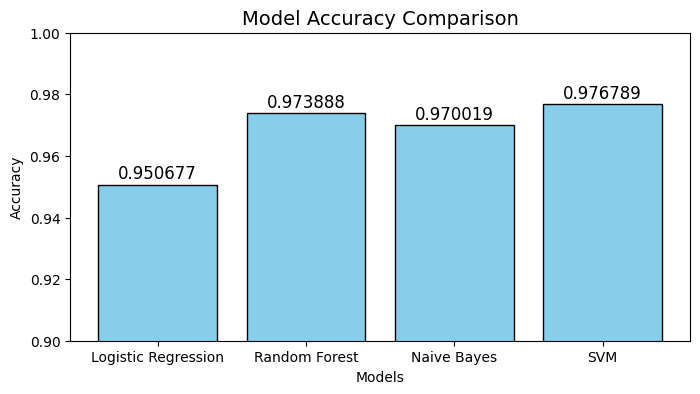

In [9]:
#Extract model names and accuracies
models = ["Logistic Regression", "Random Forest", "Naive Bayes", "SVM"]
accuracies = [lr_accuracy, rf_accuracy, nb_accuracy, svm_accuracy]

#create a bar plot
plt.figure(figsize=(8,4))
plt.bar(models, accuracies, color='skyblue', edgecolor='black')

#Add titles and labels
plt.title("Model Accuracy Comparison", fontsize=14)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0)  # Adjust limits for better visualization

#add accuracy on the top of the bars
for i, acc in enumerate(accuracies):
  plt.text(i, acc + 0.002, f"{acc:2f}", ha='center', fontsize=12)
#Display the plot
plt.show()